# В качестве проекта, возьмем датасет 'Reviews' с сайта kaggle.com. В данном датасете представлено 568454 отзыва о различных продуктах с сайта Amazon. Попробуем предсказать оценку продукта, на основе отзывов.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import lightgbm as lgb

import seaborn as sns
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
import os

In [2]:
reviews = pd.read_csv('Food\\reviews.csv')

In [5]:
reviews.head()

,Score,Text
0,5,bought vitality canned dog food products good ...
1,1,product arrived labeled jumbo salted peanuts p...
2,4,confection centuries light pillowy citrus gela...
3,2,looking secret ingredient robitussin believe g...
4,5,great taffy great price wide assortment yummy ...


In [6]:
reviews.shape

(568454, 2)

#### Возьмем из нашей выборки все отзывы, при этом отсеим стоп слова с помощью библиотеки nltk.

In [30]:
amazon_text = reviews['Text'].values
from sklearn.feature_extraction import text
for T in range(len(amazon_text)):
    amazon_text[T] = re.sub(r"[^A-Za-z0-9]", " ", amazon_text[T])
    amazon_text[T] = ' '.join([word for word in amazon_text[T].lower().split() if word not in set(text.ENGLISH_STOP_WORDS)])

#### Используем стемминг, а именно LancasterStemmer, для улучшения качества модели.

In [31]:
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
for i in range(len(amazon_text)):
    try:
        amazon_text[i] = st.stem(amazon_text[i])
    except:
        amazon_text[i] = amazon_text[i]

#### Почистим отзывы от стоп слов, представленных ниже.

In [142]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = {'so', 'his', 't', 'y', 'ours', 'herself', 
             'your', 'all', 'some', 'they', 'i', 'of', 'didn', 
             'them', 'when', 'will', 'that', 'its', 'because', 
             'while', 'those', 'my', 'don', 'again', 'her', 'if',
             'further', 'now', 'does', 'against', 'won', 'same', 
             'a', 'during', 'who', 'here', 'have', 'in', 'being', 
             'it', 'other', 'once', 'itself', 'hers', 'after', 're',
             'just', 'their', 'himself', 'theirs', 'whom', 'then', 'd', 
             'out', 'm', 'mustn', 'where', 'below', 'about', 'isn',
             'shouldn', 'wouldn', 'these', 'me', 'to', 'doesn', 'into',
             'the', 'until', 'she', 'am', 'under', 'how', 'yourself',
             'couldn', 'ma', 'up', 'than', 'from', 'themselves', 'yourselves',
             'off', 'above', 'yours', 'having', 'mightn', 'needn', 'on', 
             'too', 'there', 'an', 'and', 'down', 'ourselves', 'each',
             'hadn', 'ain', 'such', 've', 'did', 'be', 'or', 'aren', 'he', 
             'should', 'for', 'both', 'doing', 'this', 'through', 'do', 'had',
             'own', 'but', 'were', 'over', 'not', 'are', 'few', 'by', 
             'been', 'most', 'no', 'as', 'was', 'what', 's', 'is', 'you', 
             'shan', 'between', 'wasn', 'has', 'more', 'him', 'nor',
             'can', 'why', 'any', 'at', 'myself', 'very', 'with', 'we', 
             'which', 'hasn', 'weren', 'haven', 'our', 'll', 'only',
             'o', 'before', 'br'}
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return(text)

In [144]:
for i in range(len(amazon_text)):
    amazon_text[i] = textClean(amazon_text[i])

#### Сохраним датасет

In [145]:
reviews['Text'] = amazon_text
reviews.to_csv('Food\\reviews.csv',sep=',',index=None,header=True)

In [7]:
reviews.head()

,Score,Text
0,5,bought vitality canned dog food products good ...
1,1,product arrived labeled jumbo salted peanuts p...
2,4,confection centuries light pillowy citrus gela...
3,2,looking secret ingredient robitussin believe g...
4,5,great taffy great price wide assortment yummy ...


#### Посмотрим на нашу выборку подробнее.

In [9]:
reviews.describe()

,Score
count,568454.000000
mean,4.183199
std,1.310436
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


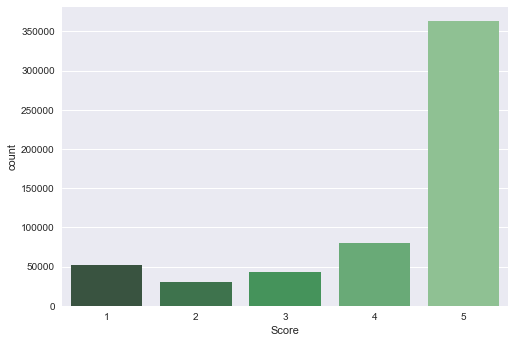

In [33]:
sns.countplot(x="Score", data=reviews, palette="Greens_d")

#### Выборка несбалансированна. Больше половины отзывов имеют оценку 5.

#### Посмотрим на самые популярные слова в нашей выборке.

In [132]:
def get_popular_words(data):
    all_data = []
    for i in range(len(data)):
        all_data.extend(data[i].split(' '))
    counter = Counter(all_data)
    counter = np.array(counter.most_common(10))
    counter = counter.transpose()
    result = []
    for i in range(10):
        for j in range(0,int(counter[1][i])):
            result.append(counter[0][i])
    return result

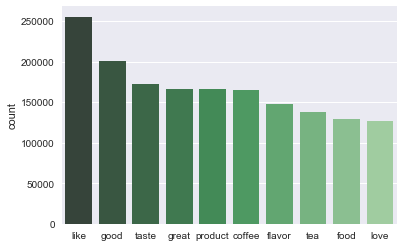

In [146]:
temp = get_popular_words(reviews.Text.values)
sns.countplot(x=temp,palette="Greens_d")

#### Популярны "положительные" слова good, taste, great, like, love, flavor, а также "нейтральные" food, tea,coffee, product.

#### Разобьем выборку отзывов на тренировочну, проверочную и тестовую, для создания модели.

In [154]:
X_train, X_text, Y_train, Y_test = train_test_split(reviews['Text'], reviews['Score'], test_size=0.2, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

#### В качестве модели в конечном итоге будем использовать библиотеку lightgbm, по этому изменим метки классов из множества {1,2,3,4,5} в множество {0,1,2,3,4}.

In [155]:
def make_good_labels(labels):
    return labels.values - 1
Y_train = make_good_labels(Y_train)
Y_test = make_good_labels(Y_test)
Y_valid = make_good_labels(Y_valid)

#### В силу того что тренировочная выборка имеет более 300000 объектов и ограниченности ресурсов, у нас нет  возможности настраивать гиперпараметры в полном объеме, так как на обучение одной модели уходит порядка 4 часов. По этому рассмотри всего две модели: в одной мы будем использовать только 1-граммы  из слов, во второй -  1-граммы, 2-граммы, 1-2-граммы. 

#### В качестве метрики качества будем использовать оценку multilogloss. Это общий случай оценки logloss для более чем двух классов.

#### Первая модель

In [54]:
%%time
count_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df = 0.75,
                        tokenizer=nltk.word_tokenize,
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=False, 
                        stop_words = 'english')
vect_X_train = count_vectorizer.fit_transform(X_train)
print(vect_X_train.shape)
vect_X_test = count_vectorizer.transform(X_text)
print(vect_X_test.shape)
vect_X_valid = count_vectorizer.transform(X_valid)
print(vect_X_test.shape)


with open('Food\\vect_X_train_1_1.pkl', 'wb') as vect_X_train_pkl:
    pickle.dump(vect_X_train, vect_X_train_pkl, protocol=2)
with open('Food\\vect_X_test_1_1.pkl', 'wb') as vect_X_test_pkl:
    pickle.dump(vect_X_test, vect_X_test_pkl, protocol=2)
with open('Food\\vect_X_valid_1_1.pkl', 'wb') as vect_X_valid_pkl:
    pickle.dump(vect_X_valid, vect_X_valid_pkl, protocol=2)

(341072, 96695)
(113691, 96695)
(113691, 96695)
Wall time: 3min 51s


In [55]:
d_train = lgb.Dataset(vect_X_train, label=Y_train)
d_val = lgb.Dataset(vect_X_valid, label=Y_valid)

#### Обучение первой модели 

In [56]:
%%time
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 13,
    'num_iterations': 100000, 
    'num_leaves': 50, 
    'min_data_in_leaf': 80, 
    'lambda_l2': 1.0,
    'feature_fraction': 0.85, 
    'bagging_fraction': 0.85, 
    'bagging_freq': 5}

model_1_1 = lgb.train(params, train_set=d_train, num_boost_round=280,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=250,
               early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[250]	dval's multi_logloss: 0.802116
[500]	dval's multi_logloss: 0.744661
[750]	dval's multi_logloss: 0.713306
[1000]	dval's multi_logloss: 0.692112
[1250]	dval's multi_logloss: 0.676572
[1500]	dval's multi_logloss: 0.664195
[1750]	dval's multi_logloss: 0.654378
[2000]	dval's multi_logloss: 0.646093
[2250]	dval's multi_logloss: 0.639297
[2500]	dval's multi_logloss: 0.633163
[2750]	dval's multi_logloss: 0.627681
[3000]	dval's multi_logloss: 0.623056
[3250]	dval's multi_logloss: 0.618955
[3500]	dval's multi_logloss: 0.615195
[3750]	dval's multi_logloss: 0.612041
[4000]	dval's multi_logloss: 0.609034
[4250]	dval's multi_logloss: 0.606381
[4500]	dval's multi_logloss: 0.603909
[4750]	dval's multi_logloss: 0.601583
[5000]	dval's multi_logloss: 0.599578
[5250]	dval's multi_logloss: 0.597659
[5500]	dval's multi_logloss: 0.59602
[5750]	dval's multi_logloss: 0.594446
[6000]	dval's multi_logloss: 0.593096
[6250]	dval's multi_logloss: 0

#### Сохранение первой модели

In [57]:
with open('Food\\model_1_1.pkl', 'wb') as model_1_1_pkl:
    pickle.dump(model_1_1, model_1_1_pkl, protocol=2)

#### Вторая модель

In [58]:
%%time
count_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df = 0.75,
                        tokenizer=nltk.word_tokenize,
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=False, 
                        stop_words = 'english')
vect_X_train = count_vectorizer.fit_transform(X_train)
print(vect_X_train.shape)
vect_X_test = count_vectorizer.transform(X_text)
print(vect_X_test.shape)
vect_X_valid = count_vectorizer.transform(X_valid)
print(vect_X_test.shape)
import pickle

with open('Food\\vect_X_train_1_2.pkl', 'wb') as vect_X_train_pkl:
    pickle.dump(vect_X_train, vect_X_train_pkl, protocol=2)
with open('Food\\vect_X_test_1_2.pkl', 'wb') as vect_X_test_pkl:
    pickle.dump(vect_X_test, vect_X_test_pkl, protocol=2)
with open('Food\\vect_X_valid_1_2.pkl', 'wb') as vect_X_valid_pkl:
    pickle.dump(vect_X_valid, vect_X_valid_pkl, protocol=2)

(341072, 3104786)
(113691, 3104786)
(113691, 3104786)
Wall time: 4min 4s


In [59]:
d_train = lgb.Dataset(vect_X_train, label=Y_train)
d_val = lgb.Dataset(vect_X_valid, label=Y_valid)

#### Обучение второй модели

In [ ]:
%%time
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 13,
    'num_iterations': 100000, 
    'num_leaves': 50, 
    'min_data_in_leaf': 80, 
    'lambda_l2': 1.0,
    'feature_fraction': 0.85, 
    'bagging_fraction': 0.85, 
    'bagging_freq': 5}

model_1_2 = lgb.train(params, train_set=d_train, num_boost_round=280,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=250,
               early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[500]	dval's multi_logloss: 0.737353
[750]	dval's multi_logloss: 0.705995
[1000]	dval's multi_logloss: 0.68506
[1250]	dval's multi_logloss: 0.66965
[1500]	dval's multi_logloss: 0.657401
[1750]	dval's multi_logloss: 0.647419
[2000]	dval's multi_logloss: 0.639154
[2250]	dval's multi_logloss: 0.632341
[2500]	dval's multi_logloss: 0.626558
[2750]	dval's multi_logloss: 0.621579
[3000]	dval's multi_logloss: 0.617094
[3250]	dval's multi_logloss: 0.613467
[3500]	dval's multi_logloss: 0.609982
[3750]	dval's multi_logloss: 0.607007
[4000]	dval's multi_logloss: 0.604248
[4250]	dval's multi_logloss: 0.601808
[4500]	dval's multi_logloss: 0.59972
[4750]	dval's multi_logloss: 0.59773
[5000]	dval's multi_logloss: 0.596009
[5250]	dval's multi_logloss: 0.594658
[5500]	dval's multi_logloss: 0.593239
[5750]	dval's multi_logloss: 0.59206
[6000]	dval's multi_logloss: 0.591045
[6250]	dval's multi_logloss: 0.589927
[6500]	dval's multi_logloss: 0.58

#### Сохранение второй модели

In [ ]:
with open('Food\\model_1_2.pkl', 'wb') as model_1_2_pkl:
    pickle.dump(model_1_2, model_1_2_pkl, protocol=2)

#### Первая модель показала лучше результат чем вторая, давайте оставим для работы ее.

In [151]:
with open('Food\\vect_X_test_1_1.pkl', 'rb') as vect_X_test_1_1_pkl:
    vect_X_test_1_1 = pickle.load(vect_X_test_1_1_pkl)
with open('Food\\model_1_1.pkl', 'rb') as model_1_1_pkl:
    model_1_1 = pickle.load(model_1_1_pkl)

In [152]:
y_predict = model_1_1.predict(vect_X_test_1_1)

#### Посчитаем multi log loss для тестовой выборки. Идея реализации взята с сайта kaggle.com

In [169]:
def multiclass_log_loss(y_true, y_predict):
    actual = np.zeros(y_predict.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(y_predict))
    return -1.0 / rows * vsota
print 'Multi log loss for test:',multiclass_log_loss(Y_test,y_predict)

Multi log loss for test: 0.5842148663


#### Значение очень близкое со значением для проверочной выборки, из чего мы можем сделать вывод об отсутствии переобучения.

#### Посмотрим на гистограммы распределений

#### Истинные значения для тестовой выборки

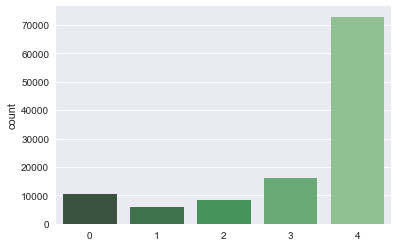

In [170]:
sns.countplot(x=Y_test,palette="Greens_d")

#### Предсказанные значения для тестовой выборки

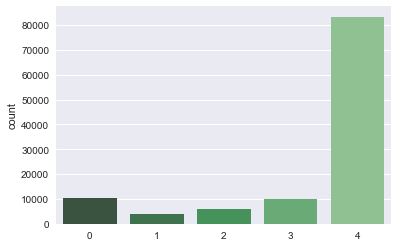

In [175]:
def get_label(data):
    label = []
    for i in range(len(data)):
        label.append(list(data[i]).index(max(data[i])))
    return label
predict_labels = get_label(y_predict)
sns.countplot(x=predict_labels,palette="Greens_d")

In [177]:
labels_df = pd.DataFrame()
labels_df['True'] = Y_test
labels_df['Predict'] = predict_labels
labels_df.head()

,True,Predict
0,4,4
1,4,4
2,4,4
3,4,4
4,4,2


In [179]:
labels_df.describe()

,True,Predict
count,113691.000000,113691.000000
mean,3.183823,3.342235
std,1.313292,1.270576
min,0.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,4.000000,4.000000
max,4.000000,4.000000


In [181]:
print 'True labels:',Counter(Y_test)
print 'Predict labels:',Counter(predict_labels)


True labels: Counter({4: 72835, 3: 15942, 0: 10556, 2: 8448, 1: 5910})
Predict labels: Counter({4: 83359, 0: 10241, 3: 10163, 2: 6129, 1: 3799})


### Выводы:

#### Нам удалось построить модель для предсказания оценки отзыва на товар. Показатель Multi log loss для тестовой выборки составляет 0.58, что является неплохим результатом. Однако, в силу несбалансированности выборки, заметно преобладание 5-ого класса, что негативно сказалось на всей модели в целом, как видно из полученных результатов, модель слишком часто предсказывает 5-ый класс. Для борьбы с этим рекомендуется сбалансировать выборку. Это можно сделать двумя способами: или увеличить выборку путем добавления отзывов из других классов, или уменьшить выборку путем удаления отзывов для пятого класса.

#### Давайте отбаланасируем выборку и попробуем построить модель снова.

In [3]:
Counter(reviews.Score)

Counter({1: 52268, 2: 29769, 3: 42640, 4: 80655, 5: 363122})

#### Возьмем только 90000 отзывов с оценкой 5

In [15]:
not_five_reviews = reviews[reviews.Score != 5]
five_reviews = reviews[reviews.Score == 5][:90000]
balanced_reviews = pd.merge(not_five_reviews,five_reviews, how = 'outer')
balanced_reviews.to_csv('Food\\balanced_reviews.csv',sep=',',index=None,header=True)

#### Разобьем выборку отзывов на тренировочну, проверочную и тестовую, для создания модели.

In [16]:
X_train, X_text, Y_train, Y_test = train_test_split(balanced_reviews['Text'], balanced_reviews['Score'], test_size=0.2, random_state=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

#### Убедимся, что распределение меток примерно одинаково в тренировочной, тестовой и проверочной выборках

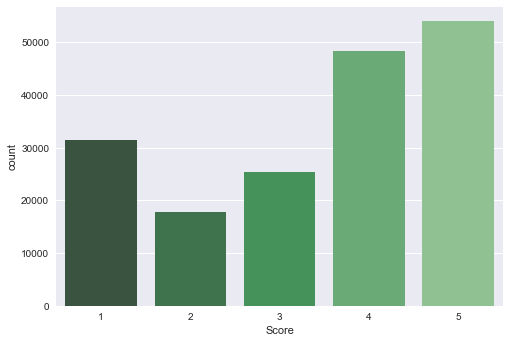

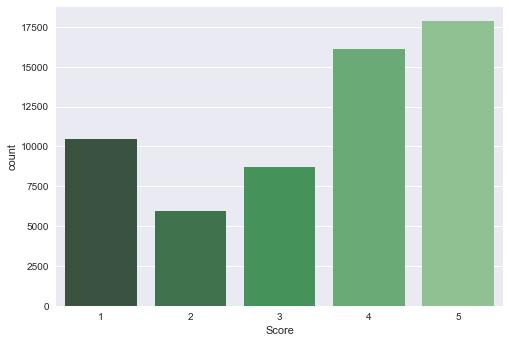

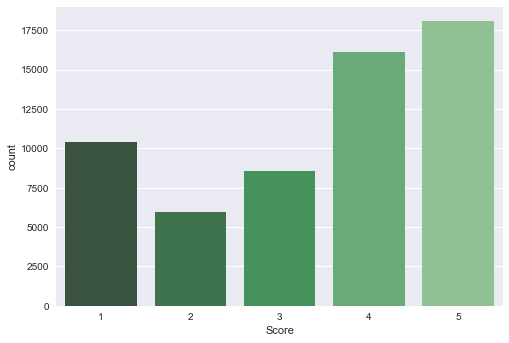

In [20]:
sns.countplot(x=Y_train,palette="Greens_d")
plt.show()
sns.countplot(x=Y_test,palette="Greens_d")
plt.show()
sns.countplot(x=Y_valid,palette="Greens_d")

#### Построим модель заново

In [21]:
%%time
count_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_df = 0.75,
                        tokenizer=nltk.word_tokenize,
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=False, 
                        stop_words = 'english')
vect_X_train = count_vectorizer.fit_transform(X_train)
print(vect_X_train.shape)
vect_X_test = count_vectorizer.transform(X_text)
print(vect_X_test.shape)
vect_X_valid = count_vectorizer.transform(X_valid)
print(vect_X_test.shape)


with open('Food\\balanced_vect_X_train_1_1.pkl', 'wb') as vect_X_train_pkl:
    pickle.dump(vect_X_train, vect_X_train_pkl, protocol=2)
with open('Food\\balanced_vect_X_test_1_1.pkl', 'wb') as vect_X_test_pkl:
    pickle.dump(vect_X_test, vect_X_test_pkl, protocol=2)
with open('Food\\balanced_vect_X_valid_1_1.pkl', 'wb') as vect_X_valid_pkl:
    pickle.dump(vect_X_valid, vect_X_valid_pkl, protocol=2)

(177198, 73359)
(59067, 73359)
(59067, 73359)
Wall time: 1min 40s


In [24]:
def make_good_labels(labels):
    return labels.values - 1
Y_train = make_good_labels(Y_train)
Y_test = make_good_labels(Y_test)
Y_valid = make_good_labels(Y_valid)


d_train = lgb.Dataset(vect_X_train, label=Y_train)
d_val = lgb.Dataset(vect_X_valid, label=Y_valid)

In [25]:
%%time
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 13,
    'num_iterations': 100000, 
    'num_leaves': 50, 
    'min_data_in_leaf': 80, 
    'lambda_l2': 1.0,
    'feature_fraction': 0.85, 
    'bagging_fraction': 0.85, 
    'bagging_freq': 5}

balanced_model_1_1 = lgb.train(params, train_set=d_train, num_boost_round=280,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=250,
               early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[250]	dval's multi_logloss: 1.11578
[500]	dval's multi_logloss: 1.04287
[750]	dval's multi_logloss: 1.00355
[1000]	dval's multi_logloss: 0.977027
[1250]	dval's multi_logloss: 0.957594
[1500]	dval's multi_logloss: 0.942199
[1750]	dval's multi_logloss: 0.929723
[2000]	dval's multi_logloss: 0.919082
[2250]	dval's multi_logloss: 0.910342
[2500]	dval's multi_logloss: 0.90301
[2750]	dval's multi_logloss: 0.896108
[3000]	dval's multi_logloss: 0.890281
[3250]	dval's multi_logloss: 0.885328
[3500]	dval's multi_logloss: 0.881067
[3750]	dval's multi_logloss: 0.877274
[4000]	dval's multi_logloss: 0.873794
[4250]	dval's multi_logloss: 0.870877
[4500]	dval's multi_logloss: 0.868253
[4750]	dval's multi_logloss: 0.865705
[5000]	dval's multi_logloss: 0.863624
[5250]	dval's multi_logloss: 0.861543
[5500]	dval's multi_logloss: 0.860107
[5750]	dval's multi_logloss: 0.858385
[6000]	dval's multi_logloss: 0.85702
[6250]	dval's multi_logloss: 0.855

#### Сохраним модель

In [26]:
with open('Food\\balanced_model_1_1.pkl', 'wb') as model_1_1_pkl:
    pickle.dump(balanced_model_1_1, model_1_1_pkl, protocol=2)

#### Посчитаем multi log loss для тестовой выборки.

In [28]:
y_predict = balanced_model_1_1.predict(vect_X_test)

In [29]:
def multiclass_log_loss(y_true, y_predict):
    actual = np.zeros(y_predict.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(y_predict))
    return -1.0 / rows * vsota
print 'Multi log loss for test:',multiclass_log_loss(Y_test,y_predict)

Multi log loss for test: 0.856768148223


#### Значение очень близкое со значением для проверочной выборки, из чего мы можем сделать вывод об отсутствии переобучения. Однако, значение multi log loss хуже, чем были до балансировки. 

#### Сравним полученные метки с истинными.

#### Истинные значения.

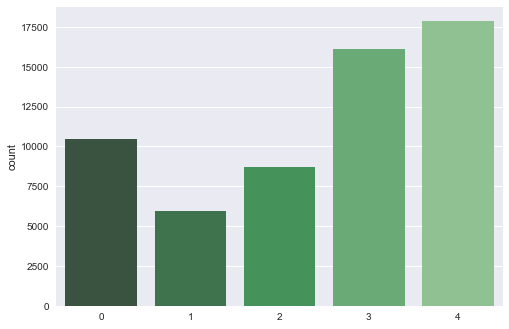

In [30]:
sns.countplot(x=Y_test,palette="Greens_d")

#### Предсказанные значения.

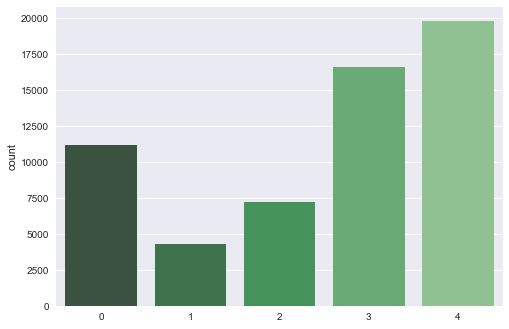

In [32]:
def get_label(data):
    label = []
    for i in range(len(data)):
        label.append(list(data[i]).index(max(data[i])))
    return label
predict_labels = get_label(y_predict)
sns.countplot(x=predict_labels,palette="Greens_d")

#### Посмотрим на точность модели.

In [33]:
labels_df = pd.DataFrame()
labels_df['True'] = Y_test
labels_df['Predict'] = predict_labels
labels_df.describe()

,True,Predict
count,59067.000000,59067.000000
mean,2.422910,2.498552
std,1.453472,1.484423
min,0.000000,0.000000
25%,1.000000,1.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,4.000000,4.000000


In [38]:
print 'Accuracy:',float(labels_df[labels_df.True == labels_df.Predict].shape[0]) / labels_df.shape[0]

Accuracy: 0.672846090033


In [40]:
print 'Accuracy with 1-step error:',(float(labels_df[labels_df.True == labels_df.Predict - 1].shape[0]) + float(labels_df[labels_df.True == labels_df.Predict + 1].shape[0]) + float(labels_df[labels_df.True == labels_df.Predict].shape[0]))/ labels_df.shape[0]

Accuracy with 1-step error: 0.89914842467


### Выводы:

#### Нам удалось построить модель для предсказания оценки отзыва на товар. Мы не столкнулись с проблемой переобучения. Точность нашей модели составляет 0.67, что для мультиклассовой классификации является неплохим результатом. При этом, если упростить шкалу оценок от "1 до 5" на "от 1 до 3", точность составляет около 0.9.